<a href="https://colab.research.google.com/github/leilahm1/O_M_sim/blob/master/O_M_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/leilahm1/O_M_sim
 
  

Cloning into 'O_M_sim'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (115/115), 1.42 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
 !ls O_M_sim

drive.py  driving_log.csv  IMG	O_M_sim.ipynb  README.md


In [5]:
!pip3 install imgaug

    100% |████████████████████████████████| 634kB 5.7MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import ntpath
import random
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [8]:
datadir='O_M_sim'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_180.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_180.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_180.jpg,0.0,0.0,0.0,7.862732
1,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_246.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_246.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_246.jpg,0.0,0.0,0.0,7.815299
2,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_314.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_314.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_314.jpg,0.0,0.0,0.0,7.768152
3,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_383.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_383.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_383.jpg,0.0,0.0,0.0,7.705731
4,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\center_2018_10_18_02_27_48_451.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\left_2018_10_18_02_27_48_451.jpg,C:\Users\Asus\Desktop\DATA_TRAINCAR\IMG\right_2018_10_18_02_27_48_451.jpg,0.0,0.0,0.0,7.659244


In [9]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_10_18_02_27_48_180.jpg,left_2018_10_18_02_27_48_180.jpg,right_2018_10_18_02_27_48_180.jpg,0.0,0.0,0.0,7.862732
1,center_2018_10_18_02_27_48_246.jpg,left_2018_10_18_02_27_48_246.jpg,right_2018_10_18_02_27_48_246.jpg,0.0,0.0,0.0,7.815299
2,center_2018_10_18_02_27_48_314.jpg,left_2018_10_18_02_27_48_314.jpg,right_2018_10_18_02_27_48_314.jpg,0.0,0.0,0.0,7.768152
3,center_2018_10_18_02_27_48_383.jpg,left_2018_10_18_02_27_48_383.jpg,right_2018_10_18_02_27_48_383.jpg,0.0,0.0,0.0,7.705731
4,center_2018_10_18_02_27_48_451.jpg,left_2018_10_18_02_27_48_451.jpg,right_2018_10_18_02_27_48_451.jpg,0.0,0.0,0.0,7.659244


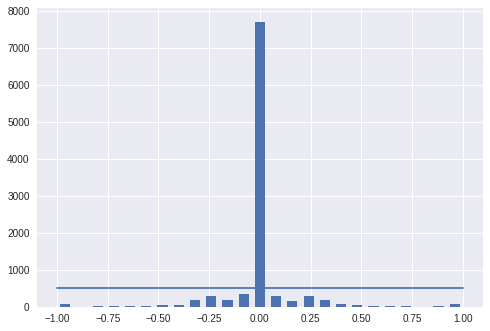

In [10]:
num_bins=25
samples_per_bin=500
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data: 10139
removed: 7190
remaining: 2949


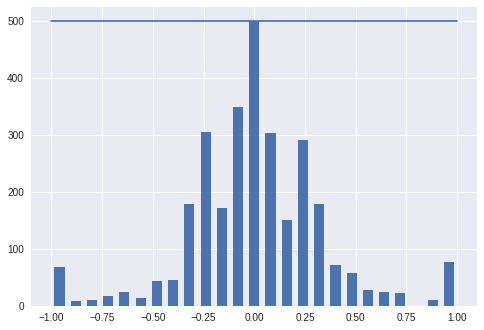

In [11]:
print('total data:',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [12]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[3]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
    
image_paths,steerings=load_img_steering(datadir+'/IMG',data)

center      center_2018_10_18_02_27_49_065.jpg
left        left_2018_10_18_02_27_49_065.jpg  
right       right_2018_10_18_02_27_49_065.jpg 
steering   -0.15                              
throttle    0.614377                          
reverse     0                                 
speed       7.99946                           
Name: 13, dtype: object


In [37]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=2)
print('Training Samples : {}\nValid Samples : {}'.format(len(X_train),len(X_valid)))

Training Samples : 2359
Valid Samples : 590


Text(0.5,1,'Validation set')

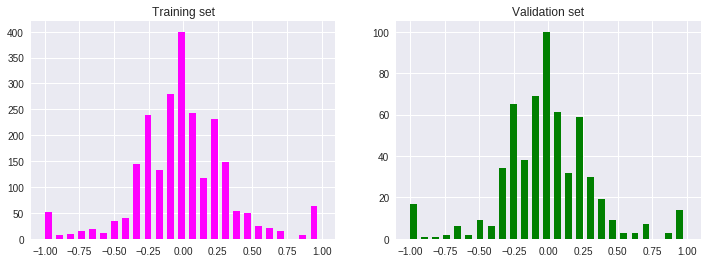

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='magenta')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

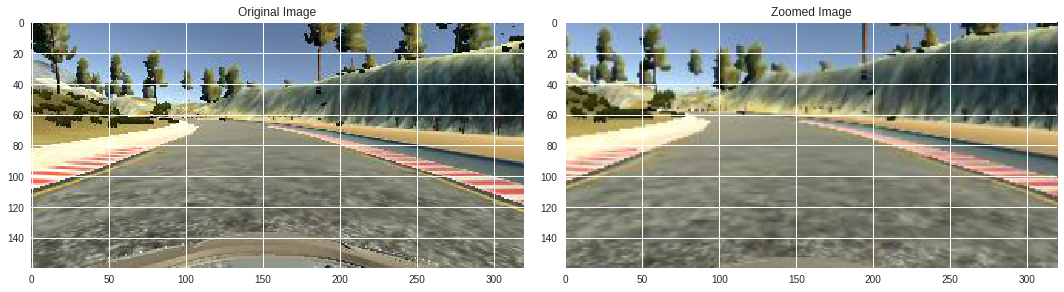

In [21]:
image=image_paths[random.randint(0,100)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5,1,'Panned image')

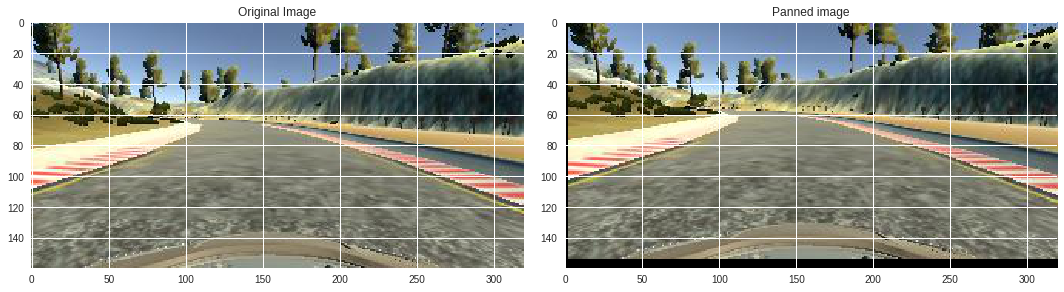

In [24]:
image=image_paths[random.randint(0,10)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5,1,'brightness_altered_image image')

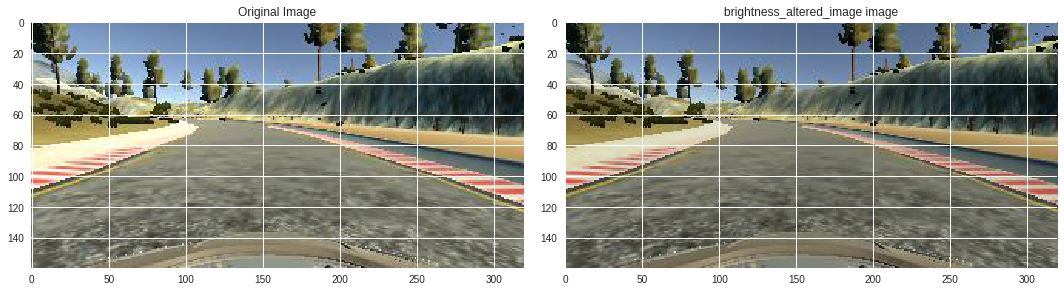

In [27]:
image=image_paths[random.randint(0,10)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness_altered_image image')

In [0]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5,1,'Flipped Image - Steering Angle:0.05')

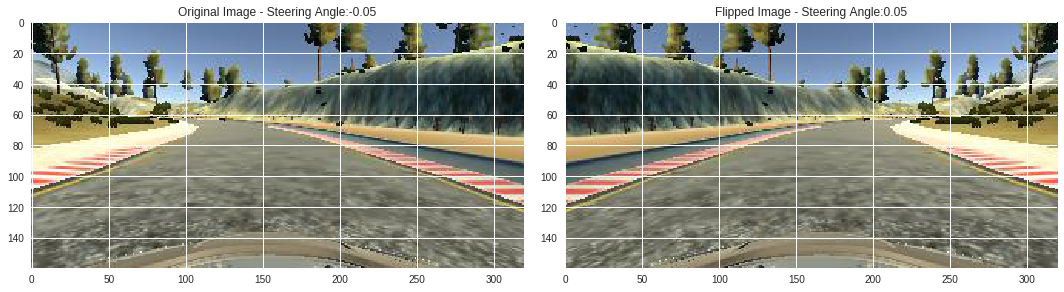

In [30]:
random_index=random.randint(0,10)
image=image_paths[random_index]
steering_angle=steerings[random_index]
original_image=mpimg.imread(image)
flipped_image,flipped_steering_angle=img_random_flip(original_image,steering_angle)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' +str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' +str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image,steering_angle

In [0]:
def img_preprocess(img):
  img=mpimg.imread(img)
  img=img[60:140,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5,1,'Preprocssed Image')

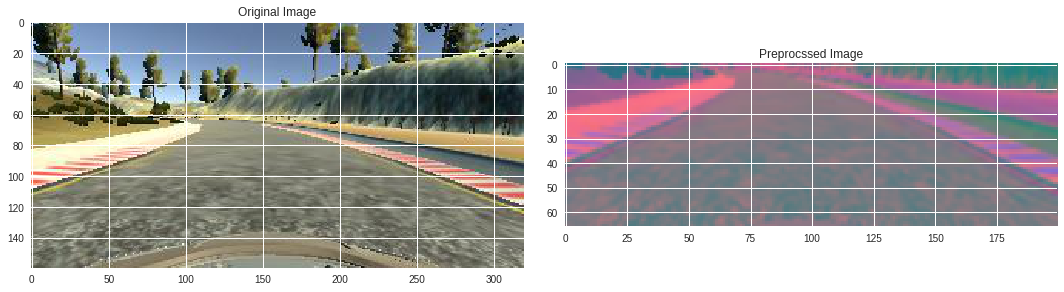

In [45]:
image = image_paths[1]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocssed Image')

In [0]:
X_train=np.array(X_train)
X_valid=np.array(X_valid)

TypeError: ignored

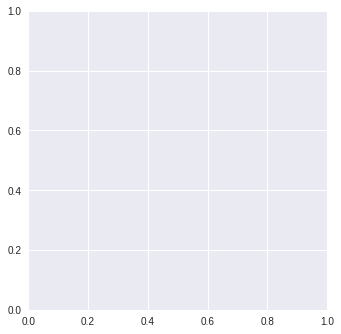

In [94]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,100,0),activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer=Adam(lr=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model

In [90]:
model=nvidia_model()
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 31, 48, 24)        24        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 22, 36)        21636     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 9, 48)          43248     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 7, 64)          27712     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 5, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               32100     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 100, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [91]:

history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,validation_split=0.2,verbose=1,shuffle=1)
  

ValueError: ignored